In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from argparse import ArgumentParser
from typing import List, Tuple

import os
import os.path
import sys
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats
import cv2

import src.data
import src.metrics
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def predict_mask(signal, N, stride, model, thr_dice, ptg_voting = 0.25, batch_size = 16):
    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(signal,(N,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=float)

    # Compute segmentation for all leads independently
    with torch.no_grad():
        for i in range(0,windowed_signal.shape[0],batch_size):
            inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).cuda().float()}
            windowed_mask[i:i+batch_size] = model.cuda()(inputs)["sigmoid"].cpu().detach().numpy() > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((signal.shape[0]), dtype=int)
    segmentation = np.zeros((3,signal.shape[0]))

    for i in range(0,windowed_mask.shape[0],12):
        counter[(i//12)*stride:(i//12)*stride+N] += 1
        segmentation[:,(i//12)*stride:(i//12)*stride+N] += windowed_mask[i:i+12].sum(0)
    segmentation = ((segmentation/counter) >= (signal.shape[-1]*ptg_voting))

    return segmentation

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

def get_ground_truth(basedir: str, database: str):
    if database == 'ludb':
        # Load data
        P = sak.load_data(os.path.join(basedir,"ludb","P.csv"))
        QRS = sak.load_data(os.path.join(basedir,"ludb","QRS.csv"))
        T = sak.load_data(os.path.join(basedir,"ludb","T.csv"))
    elif database == 'zhejiang':
        # Load data
        P = sak.load_data(os.path.join(basedir,"ZhejiangDB","P.csv"))
        QRS = sak.load_data(os.path.join(basedir,"ZhejiangDB","QRS.csv"))
        T = sak.load_data(os.path.join(basedir,"ZhejiangDB","T.csv"))
        
    # Divide into onsets/offsets
    Pon    = {k: P[k][0::2] for k in P}
    Poff   = {k: P[k][1::2] for k in P}
    QRSon  = {k: QRS[k][0::2] for k in QRS}
    QRSoff = {k: QRS[k][1::2] for k in QRS}
    Ton    = {k: T[k][0::2] for k in T}
    Toff   = {k: T[k][1::2] for k in T}

    # Generate validity
    validity = {
        k: [
            np.min(np.concatenate((P.get(k,[+np.inf]),QRS.get(k,[+np.inf]),T.get(k,[+np.inf])))),
            np.max(np.concatenate((P.get(k,[-np.inf]),QRS.get(k,[-np.inf]),T.get(k,[-np.inf])))),
        ] for k in QRS
    }
    return Pon,Poff,QRSon,QRSoff,Ton,Toff,validity
 
def get_file_list(basedir: str, database: str):
    if database == 'ludb':
        files = glob.glob(os.path.join(basedir,'ludb','*.dat'))
    elif database == 'zhejiang':
        files = glob.glob(os.path.join(basedir,'ZhejiangDB','RAW','*.csv'))
    return files
 
def get_sample(file: str, database: str) -> Tuple[float, np.ndarray]:
    if database == 'ludb':
        (signal, header) = wfdb.rdsamp(os.path.splitext(file)[0])
        fs = header['fs']
    elif database == 'zhejiang':
        signal = pd.read_csv(file).values
        fs = 2000.
    return signal, fs



In [11]:
basedir='/home/guille/DADES/DADES/Delineator/'
model_name='WNet5BoundLoss_20201026000000'
database='zhejiang'
model_type='model_best'
batch_size=16
window_size=2048
hpc=False
use_morph=False

In [6]:
target_width = 2500
down_factor = 4
listfiles = glob.glob(os.path.join(basedir,'PVCVTRawECGData','*.csv'))

# Crop QRS waves?
crop_qrs = True

# Instantiate figure
for i,file in enumerate(tqdm.tqdm(listfiles)):
    # Get UID
    root,fname = os.path.split(file)
    fname,ext = os.path.splitext(fname)
    
    # Read file
    try:
        signal = pd.read_csv(os.path.join(basedir,'PVCVTECGData',f'{fname}.csv'))
    except:
        continue
    
    # Downsample signal to 250Hz (faster loading, etc)
    signal = sp.signal.decimate(signal,down_factor,axis=0)

    # Filter baseline wander
    signal = sp.signal.filtfilt(*sp.signal.butter(4,   0.75/250., 'high'),signal.T).T
    
    # Retrieve segmentation
    try:
        pon,poff =       P[f"{fname}###I"][::2]//down_factor,  P[f"{fname}###I"][1::2]//down_factor
        qrson,qrsoff = QRS[f"{fname}###I"][::2]//down_factor,QRS[f"{fname}###I"][1::2]//down_factor
        ton,toff =       T[f"{fname}###I"][::2]//down_factor,  T[f"{fname}###I"][1::2]//down_factor
    except:
        continue
    
    # Get x limits
    minimum = min(np.concatenate([pon,poff,qrson,qrsoff,ton,toff]))
    maximum = max(np.concatenate([pon,poff,qrson,qrsoff,ton,toff]))
    width = maximum-minimum
    diff = (target_width-width)//2
    if diff < 50:
        diff = 50
        
    amgnasdmg

  0%|          | 0/336 [00:00<?, ?it/s]


NameError: name 'amgnasdmg' is not defined

In [12]:
#########################################################################
# Load validation distribution
valid_folds = sak.load_data(os.path.join(basedir,'TrainedModels',model_name,'validation_files.csv'),dtype=None)
fold_of_file = {fname: k for k in valid_folds for fname in valid_folds[k]}

#########################################################################
# Load models
models = {}
for i in range(5):
    if os.path.isfile(os.path.join(basedir,'TrainedModels',model_name,'fold_{}'.format(i+1),'{}.model'.format(model_type))):
        models['fold_{}'.format(i+1)] = torch.load(os.path.join(basedir,'TrainedModels',model_name,'fold_{}'.format(i+1),'{}.model'.format(model_type)),pickle_module=dill).eval().float()
    else:
        print("File for fold {} not found. Continuing...".format(i+1))

#########################################################################
# Load ground truth
Pon, Poff, QRSon, QRSoff, Ton, Toff, validity = get_ground_truth(basedir, database)

#########################################################################
# Retrieve file list
files = get_file_list(basedir, database)

# Initialize output structures
PredictedPon = {}
PredictedPoff = {}
PredictedQRSon = {}
PredictedQRSoff = {}
PredictedTon = {}
PredictedToff = {}
predictions = {}

# Iterate over signals
window_size = 2**11
stride = 128
thr_dice = 0.8
ptg_voting = 0.5
target_fs = 250.
for i,file in enumerate(tqdm.tqdm(files)):
    # Load singal
    (signal, fs) = get_sample(file, database.lower())
    root,fname = os.path.split(file)
    fname, ext = os.path.splitext(fname)

    # Downsample signal
    down_factor = int(fs/250.)
    signal = sp.signal.decimate(signal,down_factor,axis=0)

    # Filter signal
    signal = sp.signal.filtfilt(*sp.signal.butter(4, 75.0/250.,  'low'),signal.T).T

    # Compute moving operation for matching amplitude criteria to development set
    ampl = np.median(sak.signal.moving_lambda(signal,200,lambda x: np.max(x,axis=0)-np.min(x,axis=0)),axis=0)

    # Normalize and pad signal for inputing in algorithm
    if signal.shape[0] < window_size:
        signal = np.pad(signal,((0,math.ceil(signal.shape[0]/window_size)*window_size-signal.shape[0]),(0,0)),mode='edge')
    if (signal.shape[0]-window_size)%stride != 0:
        signal = np.pad(signal,((0,math.ceil((signal.shape[0]-window_size)/stride)*stride-(signal.shape[0]%window_size)),(0,0)),mode='edge')

    # Correct amplitudes
    signal = signal/ampl

    # Obtain segmentation
    for j,fold in enumerate(models):
        m = models[fold]
        if j == 0:
            segmentation = predict_mask(signal, window_size, stride, m, thr_dice, ptg_voting, batch_size).astype(int)
        else:
            segmentation += predict_mask(signal, window_size, stride, m, thr_dice, ptg_voting, batch_size)

    segmentation = segmentation >= 3

    # Morphological operations
    if use_morph:
        p               = cv2.morphologyEx(segmentation[0,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
        qrs             = cv2.morphologyEx(segmentation[1,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
        t               = cv2.morphologyEx(segmentation[2,:].astype('float32'), cv2.MORPH_CLOSE, np.ones((5,))).squeeze()
        segmentation[0,:] = cv2.morphologyEx(p,   cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)
        segmentation[1,:] = cv2.morphologyEx(qrs, cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)
        segmentation[2,:] = cv2.morphologyEx(t,   cv2.MORPH_OPEN,  np.ones((5,))).squeeze().astype(bool)

    # Obtain onsets/offsets
    pon,poff = sak.signal.get_mask_boundary(segmentation[0,:])
    qrson,qrsoff = sak.signal.get_mask_boundary(segmentation[1,:])
    ton,toff = sak.signal.get_mask_boundary(segmentation[2,:])

    # Save stuff
    PredictedPon[fname] = (np.array(pon)*down_factor).tolist()
    PredictedPoff[fname] = (np.array(poff)*down_factor).tolist()
    PredictedQRSon[fname] = (np.array(qrson)*down_factor).tolist()
    PredictedQRSoff[fname] = (np.array(qrsoff)*down_factor).tolist()
    PredictedTon[fname] = (np.array(ton)*down_factor).tolist()
    PredictedToff[fname] = (np.array(toff)*down_factor).tolist()

    # Retrieve mask as 1D
    predictions[fname] = segmentation
    
    adskgljhjaglj


  0%|          | 0/334 [00:00<?, ?it/s]


NameError: name 'adskgljhjaglj' is not defined

# BoundDiceLoss1d function

In [17]:
self = nn.BoundDiceLoss1d(3)

In [34]:
target = np.zeros_like(segmentation,dtype=bool)

for i,wave in enumerate(["P", "QRS", "T"]):
    onsets = eval(f"{wave}on")[f"{fname}###I"]
    offsets = eval(f"{wave}off")[f"{fname}###I"]
    
    for on,off in zip(onsets,offsets):
        on = on//down_factor
        off = off//down_factor
        target[i,on:off] = 1

input = torch.tensor(segmentation.copy().astype("float32"))[None,]
target = torch.tensor(target.copy().astype("float32"))[None,]

In [60]:
# Move operation to device
self.conv_op = self.conv_op.to(target.device)

# Retrieve boundaries
boundary_input = self.conv_op(input.clone()).abs()[0].cpu().numpy()
boundary_target = self.conv_op(target.clone()).abs()[0].cpu().numpy()


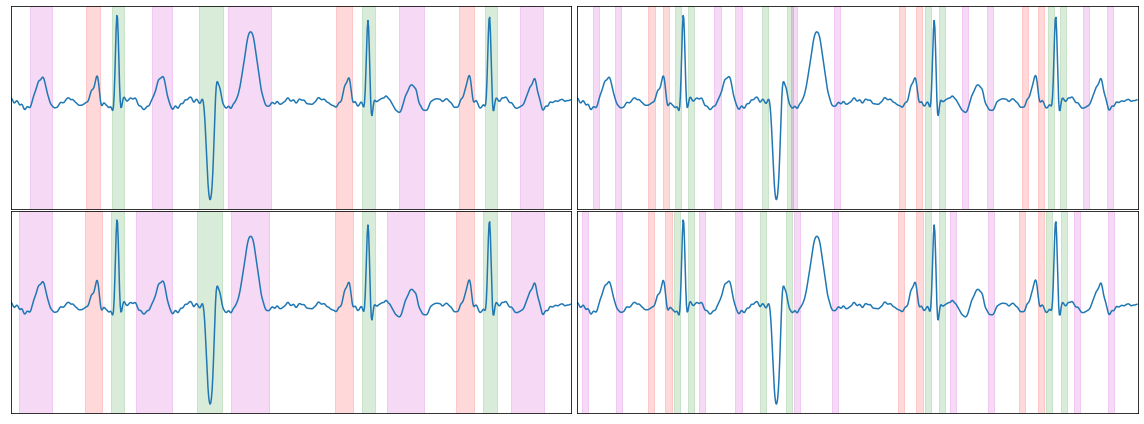

In [82]:
f,ax=plt.subplots(nrows=2,ncols=2,figsize=(16,6))
xon = 100
xoff = 1024
ax[0,0].plot(signal[xon:xoff,3])
ax[0,1].plot(signal[xon:xoff,3])
ax[1,0].plot(signal[xon:xoff,3])
ax[1,1].plot(signal[xon:xoff,3])

colors=["r","g","m"]

for i,seg in enumerate(target.clone()[0].cpu().numpy()):
    onsets,offsets = sak.signal.get_mask_boundary(seg[xon:xoff])
    
    for on,off in zip(onsets,offsets):
        ax[0,0].axvspan(on,off,color=colors[i],alpha=0.15)
        
for i,seg in enumerate(boundary_target):
    onsets,offsets = sak.signal.get_mask_boundary(seg[xon:xoff])
    
    for on,off in zip(onsets,offsets):
        ax[0,1].axvspan(on,off,color=colors[i],alpha=0.15)
        

for i,seg in enumerate(input.clone()[0].cpu().numpy()):
    onsets,offsets = sak.signal.get_mask_boundary(seg[xon:xoff])
    # onsets = (np.array(onsets)+on).tolist()
    # offsets = (np.array(offsets)+on).tolist()
    
    for on,off in zip(onsets,offsets):
        ax[1,0].axvspan(on,off,color=colors[i],alpha=0.15)
        
for i,seg in enumerate(boundary_input):
    onsets,offsets = sak.signal.get_mask_boundary(seg[xon:xoff])
    # onsets = (np.array(onsets)+on).tolist()
    # offsets = (np.array(offsets)+on).tolist()
    
    for on,off in zip(onsets,offsets):
        ax[1,1].axvspan(on,off,color=colors[i],alpha=0.15)
        

ax[0,0].set_xlim([xon,xoff-xon])
ax[0,1].set_xlim([xon,xoff-xon])
ax[1,0].set_xlim([xon,xoff-xon])
ax[1,1].set_xlim([xon,xoff-xon])

ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

f.tight_layout()
f.subplots_adjust(wspace=0.01,hspace=0.01)
f.savefig('/home/guille/boundloss.svg')

# F1InstanceLoss1d function

In [83]:
self = nn.F1InstanceLoss1d(3)

In [84]:
target = np.zeros_like(segmentation,dtype=bool)

for i,wave in enumerate(["P", "QRS", "T"]):
    onsets = eval(f"{wave}on")[f"{fname}###I"]
    offsets = eval(f"{wave}off")[f"{fname}###I"]
    
    for on,off in zip(onsets,offsets):
        on = on//down_factor
        off = off//down_factor
        target[i,on:off] = 1

input = torch.tensor(segmentation.copy().astype("float32"))[None,]
target = torch.tensor(target.copy().astype("float32"))[None,]

In [85]:
# Move operation to device
self.prewitt = self.prewitt.to(target.device)

# Retrieve boundaries
input_boundary = self.prewitt(input).abs()
target_boundary = self.prewitt(target).abs()

# Sum of elements alongside the spatial dimensions
input_elements = input_boundary.sum(-1)/4
target_elements = target_boundary.sum(-1)/4

# Apply class weights
if self.weight is not None:
    # Assert compatible shapes
    assert self.weight.shape[-1] == input.shape[1], "The number of channels and provided class weights does not coincide"
    self.weight = self.weight.to(target.device)
    input_elements = input_elements*self.weight
    target_elements = target_elements*self.weight

# F1 loss
truepositive  = (target_elements-(target_elements-input_elements).clamp_min(0)).abs()
falsepositive = (input_elements-target_elements).clamp_min(0)
falsenegative = (target_elements-input_elements).clamp_min(0)


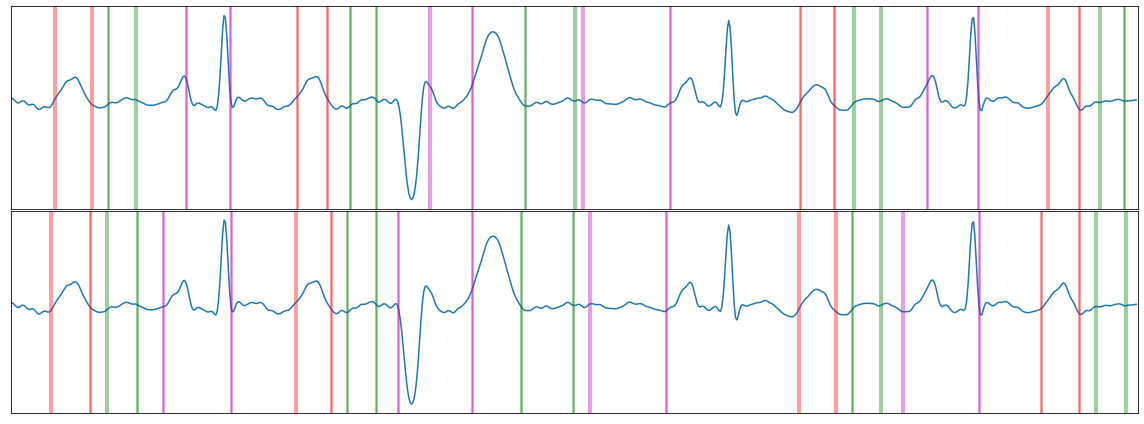

In [112]:
f,ax=plt.subplots(nrows=2,ncols=1,figsize=(16,6))
xon = 100
xoff = 1024
ax[0].plot(signal[xon:xoff,3])
ax[1].plot(signal[xon:xoff,3])

colors=["r","g","m"]

for i,seg in enumerate(target_boundary.clone()[0].numpy()):
    locs = np.where(seg)[0]
    
    for loc in locs:
        ax[0].axvline(x=loc,color=colors[i],alpha=0.5)
        

for i,seg in enumerate(input_boundary.clone()[0].numpy()):
    locs = np.where(seg)[0]
    
    for loc in locs:
        ax[1].axvline(x=loc,color=colors[i],alpha=0.5)
        

ax[0].set_xlim([xon,xoff-xon])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xlim([xon,xoff-xon])
ax[1].set_xticks([])
ax[1].set_yticks([])

f.tight_layout()
f.subplots_adjust(wspace=0.01,hspace=0.01)
f.savefig('/home/guille/f1instanceloss.svg')

# Beat-to-beat redundancy

In [115]:
files = get_file_list(basedir, "ludb")
file = np.random.choice(files)
root,fname = os.path.split(file)
fname,ext = os.path.splitext(fname)

In [117]:
sample,fs = get_sample(file, "ludb")

In [139]:
def standard_tmp(
        x: np.ndarray, 
        y: np.ndarray = None, 
        header: list = None, 
        returns: bool = False, 
        **kwargs: dict
    ):

    # Check input data
    if y is None:
        y = x
        x = np.arange(y.shape[0])
    if x.shape[0] != y.shape[0]:
        raise ValueError("x and y vectors inputted with different shapes '{}' and '{}'".format(x.shape[0],y.shape[0]))

    # Set default values
    kwargs['figsize'] = kwargs.get('figsize', (4,12))

    fig,ax = plt.subplots(nrows = 6, ncols = 2, **kwargs)
    if x.ndim > 1:
        [ax[i%6][i//6].plot(x[:,i], y[:,i]) for i in range(y.shape[1])]
    else:
        [ax[i%6][i//6].plot(x, y[:,i]) for i in range(y.shape[1])]
        
    if header is not None:
        [ax[i%6][i//6].set_title(header[i]) for i in range(len(header))]

    # Set y ticks to the right in the right column
    for i in range(6):
        ax[i%6][1].yaxis.tick_right()

    # Set limits
    [[ax[i,j].set_xlim([x[0],x[-1]]) for j in range(ax.shape[1])] for i in range(ax.shape[0])]

    if returns:
        return fig,ax


In [145]:
StandardHeader[3]

'AVR'

In [148]:
Pon,Poff,QRSon,QRSoff,Ton,Toff,validity = get_ground_truth(basedir,"ludb")

3it [00:00, 45.98it/s]


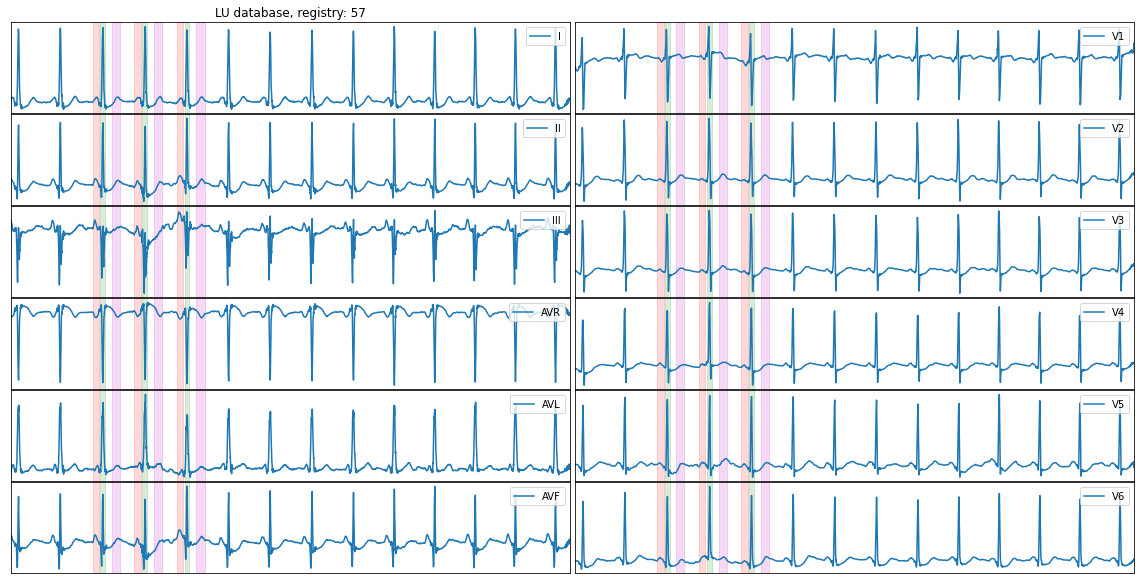

In [155]:
f,ax = standard_tmp(sample,figsize=(16,8),returns=True)

colors=["r","g","m"]

[ax[i,j].set_xlim([0,sample.shape[0]]) for i in range(6) for j in range(2)]
[ax[i,j].set_xticks([]) for i in range(6) for j in range(2)]
[ax[i,j].set_yticks([]) for i in range(6) for j in range(2)]
for k,wave in tqdm.tqdm(enumerate(["P", "QRS", "T"])):
    onsets = eval(f"{wave}on")[f"{fname}###I"]
    offsets = eval(f"{wave}off")[f"{fname}###I"]
    for on,off in zip(onsets,offsets):
        [ax[i,j].axvspan(on,off,color=colors[k],alpha=0.15) for i in range(6) for j in range(2)]
[ax[i,j].legend([StandardHeader[j*6+i]],loc='upper right') for i in range(6) for j in range(2)]
f.tight_layout()
f.subplots_adjust(wspace=0.01,hspace=0.01)
ax[0,0].set_title(f"LU database, registry: {fname}")
f.savefig('/home/guille/redundancy.svg')

# Randomly drawn samples

In [159]:
config_file = './configurations/WNet5Levels.json'
input_files = './pickle/'
bool_hpc = False

In [162]:
##### 1. Load configuration file #####
with open(config_file, "r") as f:
    execution = json.load(f)

execution["root_directory"] = os.path.expanduser(execution["root_directory"])
execution["save_directory"] = os.path.expanduser(execution["save_directory"])

# NO ITERATOR FOR HPC, WASTE OF MEMORY
if bool_hpc:
    execution["iterator"] = "none"

##### 2. Load synthetic dataset #####
# 2.1. Load individual segments
P = sak.pickleload(os.path.join(input_files,"Psignal_new.pkl"))
PQ = sak.pickleload(os.path.join(input_files,"PQsignal_new.pkl"))
QRS = sak.pickleload(os.path.join(input_files,"QRSsignal_new.pkl"))
ST = sak.pickleload(os.path.join(input_files,"STsignal_new.pkl"))
T = sak.pickleload(os.path.join(input_files,"Tsignal_new.pkl"))
TP = sak.pickleload(os.path.join(input_files,"TPsignal_new.pkl"))

Pamplitudes = sak.pickleload(os.path.join(input_files,"Pamplitudes_new.pkl"))
PQamplitudes = sak.pickleload(os.path.join(input_files,"PQamplitudes_new.pkl"))
QRSamplitudes = sak.pickleload(os.path.join(input_files,"QRSamplitudes_new.pkl"))
STamplitudes = sak.pickleload(os.path.join(input_files,"STamplitudes_new.pkl"))
Tamplitudes = sak.pickleload(os.path.join(input_files,"Tamplitudes_new.pkl"))
TPamplitudes = sak.pickleload(os.path.join(input_files,"TPamplitudes_new.pkl"))

# 2.2. Get amplitude distribution
Pdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Pamplitudes.values()))))
PQdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(PQamplitudes.values()))))
QRSdistribution = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.hstack((np.array(list(QRSamplitudes.values())), 2-np.array(list(QRSamplitudes.values()))))))
STdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(STamplitudes.values()))))
Tdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Tamplitudes.values()))))
TPdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(TPamplitudes.values()))))

# 2.3. Smooth all
window = 5
P   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  P[k],window)),metric=sak.signal.abs_max) for k in   P}
PQ  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( PQ[k],window)),metric=sak.signal.abs_max) for k in  PQ}
QRS = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(QRS[k],window)),metric=sak.signal.abs_max) for k in QRS}
ST  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( ST[k],window)),metric=sak.signal.abs_max) for k in  ST}
T   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  T[k],window)),metric=sak.signal.abs_max) for k in   T}
TP  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( TP[k],window)),metric=sak.signal.abs_max) for k in  TP}


##### 3. Generate random splits #####
# 3.1. Split into train and test
all_keys_synthetic = {}
for k in list(P) + list(PQ) + list(QRS) + list(ST) + list(T) + list(TP):
    uid = k.split("###")[0].split("_")[0].split("-")[0]
    if uid not in all_keys_synthetic:
        all_keys_synthetic[uid] = [k]
    else:
        all_keys_synthetic[uid].append(k)

# 3.2. Get database and file
filenames = []
database = []
for k in all_keys_synthetic:
    filenames.append(k)
    if k.startswith("SOO"):
        database.append(0)
    elif k.startswith("sel"):
        database.append(1)
    else:
        database.append(2)
filenames = np.array(filenames)
database = np.array(database)

original_length = execution["dataset"]["length"]

# Set random seed for the execution and perform train/test splitting
random.seed(execution["seed"])
np.random.seed(execution["seed"])
torch.random.manual_seed(execution["seed"])
splitter = sklearn.model_selection.StratifiedKFold(5).split(filenames,database)
splits = list(splitter)
indices_train = [s[0] for s in splits]
indices_valid = [s[1] for s in splits]

# 5.3. Iterate over folds
for i,(ix_train,ix_valid) in enumerate(zip(indices_train,indices_valid)):
    print("################# FOLD {} #################".format(i+1))
    # Synthetic keys
    train_keys_synthetic, valid_keys_synthetic = ([],[])
    for k in np.array(filenames)[ix_train]: 
        train_keys_synthetic += all_keys_synthetic[k]
    for k in np.array(filenames)[ix_valid]: 
        valid_keys_synthetic += all_keys_synthetic[k]

    # Avoid repetitions
    train_keys_synthetic = list(set(train_keys_synthetic))
    valid_keys_synthetic = list(set(valid_keys_synthetic))

    # ~~~~~~~~~~~~~~~~~~~~ Refine synthetic set ~~~~~~~~~~~~~~~~~~~~
    # Divide train/valid segments
    Ptrain   = {k:   P[k] for k in   P if k in train_keys_synthetic}
    PQtrain  = {k:  PQ[k] for k in  PQ if k in train_keys_synthetic}
    QRStrain = {k: QRS[k] for k in QRS if k in train_keys_synthetic}
    STtrain  = {k:  ST[k] for k in  ST if k in train_keys_synthetic}
    Ttrain   = {k:   T[k] for k in   T if k in train_keys_synthetic}
    TPtrain  = {k:  TP[k] for k in  TP if k in train_keys_synthetic}

    Pvalid   = {k:   P[k] for k in   P if k in valid_keys_synthetic}
    PQvalid  = {k:  PQ[k] for k in  PQ if k in valid_keys_synthetic}
    QRSvalid = {k: QRS[k] for k in QRS if k in valid_keys_synthetic}
    STvalid  = {k:  ST[k] for k in  ST if k in valid_keys_synthetic}
    Tvalid   = {k:   T[k] for k in   T if k in valid_keys_synthetic}
    TPvalid  = {k:  TP[k] for k in  TP if k in valid_keys_synthetic}

    # Define synthetic datasets
    execution["dataset"]["length"] = original_length + 7086 # Size difference of oversampled multi dataset (equal computational budget)
    dataset_train_synthetic = src.data.Dataset(Ptrain, QRStrain, Ttrain, PQtrain, STtrain, TPtrain, 
                                               Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
                                               STdistribution, TPdistribution, **execution["dataset"])
    execution["dataset"]["length"] = original_length//4 + 7086 # Size difference of oversampled multi dataset (equal computational budget)
    dataset_valid_synthetic = src.data.Dataset(Pvalid, QRSvalid, Tvalid, PQvalid, STvalid, TPvalid, 
                                               Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
                                               STdistribution, TPdistribution, **execution["dataset"])
    execution["dataset"]["length"] = original_length

    # Create dataloaders
    execution["loader"]["shuffle"] = True # Force shuffle
    loader_train = torch.utils.data.DataLoader(dataset_train_synthetic, **execution["loader"])
    loader_valid = torch.utils.data.DataLoader(dataset_valid_synthetic, **execution["loader"])

    dkjasghdkjsgh


################# FOLD 1 #################


NameError: name 'dkjasghdkjsgh' is not defined

In [179]:
counter = 0

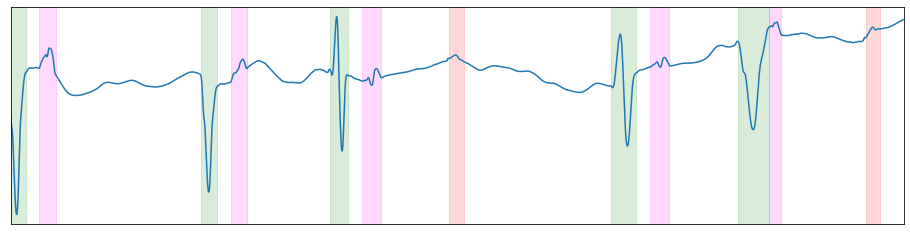

In [229]:
sample = dataset_train_synthetic[0]

f,ax=sak.visualization.signal.segmentation(sample["x"][0],sample["y"],returns=True)
ax.set_xlim([0,2048])
ax.set_xticks([])
ax.set_yticks([])
f.savefig(f'/home/guille/synthetic_{counter}.svg')

counter += 1